In [18]:
import h5py
import numpy as np
import os
import pandas as pd
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import bacco
import baccoemu

import matplotlib
from matplotlib import pyplot as plt

In [19]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

## Bacco setup

In [3]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=sigma8,
        #tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
    
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2024-01-15 23:55:55,734 bacco.cosmo :    initialization took 0.000 secs


In [4]:
ngrid = 256 #1024 #512 #256 #128 #256 #1400
#nmean=0.01 not used
BoxSize=100/hubble
print(BoxSize)

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}}) 
bacco.configuration.update({'pknbody' : {'interlacing' : True}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

149.0090895544628


## Load SAM data from hdf5 files

In [5]:
redshift = 0
dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

In [6]:
#fns_dat = [join(dir_dat, f) for f in listdir(dir_dat) if isfile(join(dir_dat, f))]
idxs_sam = [idx_sam for idx_sam in np.arange(0, 50) if isfile(f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5')]
# get first N for this notebook
idxs_sam = idxs_sam[:30]
n_sams = len(idxs_sam)
fns_dat = [f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5' for idx_sam in idxs_sam]

In [7]:
n_sams = len(fns_dat)

## Load PROVABGS data

Downloaded from https://zenodo.org/records/8018936

In [8]:
# probabilistic SMFs
fn_psmf_bgs_q = '../data/data_provabgs/psmf.sv3.bgs_bright_q.z0.01_0.05.dat'
ms, psmf_bgs_q_mean, psmf_bgs_q_std = np.loadtxt(fn_psmf_bgs_q, unpack=True)

fn_psmf_bgs_sf = '../data/data_provabgs/psmf.sv3.bgs_bright_sf.z0.01_0.05.dat'
ms, psmf_bgs_sf_mean, psmf_bgs_sf_std = np.loadtxt(fn_psmf_bgs_sf, unpack=True)

In [9]:
# combine sf and q (star-forming and quiescent)
psmf_bgs_mean = psmf_bgs_sf_mean + psmf_bgs_q_mean
psmf_bgs_std = np.sqrt(psmf_bgs_sf_std**2 + psmf_bgs_q_std**2)

In [10]:
# standard (non-probabilistic) SMF, as check
fn_smf_bgs = '../data/data_provabgs/smf.standard.sv3.bgs_bright.z0.01_0.05.dat'
ms_smf, smf_bgs = np.loadtxt(fn_smf_bgs, unpack=True)

## Plot CAMELS SMFs

In [11]:
log_mass_shift = 9
h = 0.6711 # from perez et al
print(h**3)
vol_Mpc = (100/h)**3 # 100 Mpc/h = 100/h Mpc
vol_hMpc = 100**3 # units Mpc/h!! to match bgs; diff than plotted in camels paper
print(vol_Mpc, vol_hMpc)

0.302246803431
3308554.428527777 1000000


In [12]:
edges = np.linspace(8, 12.5, 40)

bin_width = edges[1] - edges[0]                
bins_avg = edges[0:-1] + bin_width/2.           

In [13]:
smf_arr = []
nbar_arr = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        mstar_raw = np.array(f['mstar'])
        log_mstar = np.log10(mstar_raw) + log_mass_shift
        
        phi, edges = np.histogram(log_mstar, bins=edges)   
        smf = phi / vol_Mpc / bin_width
        smf_arr.append(smf)    
        
        nbar_arr.append(len(mstar_raw)/vol_Mpc)

/tmp/ipykernel_321670/292810891.py:7: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift


In [14]:
def get_distance_sigma(x1, y1, yerr1, x2, y2, xrange):
    xmin, xmax = xrange

    y1 = y1[(x1>=xmin) & (x1<xmax)]
    yerr1 = yerr1[(x1>=xmin) & (x1<xmax)]
    y2 = y2[(x2>=xmin) & (x2<xmax)]

    x1 = x1[(x1>=xmin) & (x1<xmax)]
    x2 = x2[(x2>=xmin) & (x2<xmax)]
    
    # interpolate y2 to be at the same x-vals as x2/y2
    y2_interp = np.interp(x1, x2, y2)
    sigmas = (y2_interp - y1)/yerr1
    sigma_mean = np.mean(np.abs(sigmas))
    return sigma_mean

In [20]:
sigma_means = []
xrange = [9,11]
for i in range(n_sams):
    
    sigma_mean = get_distance_sigma(ms, psmf_bgs_mean, psmf_bgs_std, bins_avg, smf_arr[i], xrange)
    sigma_means.append(sigma_mean)
sigma_means = np.array(sigma_means)

In [21]:
locs_norm = matplotlib.colors.Normalize(np.min(sigma_means), np.max(sigma_means), len(sigma_means))
cmap = matplotlib.cm.get_cmap('cool_r')
colors = cmap(locs_norm(sigma_means))

/tmp/ipykernel_41281/431812615.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('cool_r')


(8.0, 12.5)

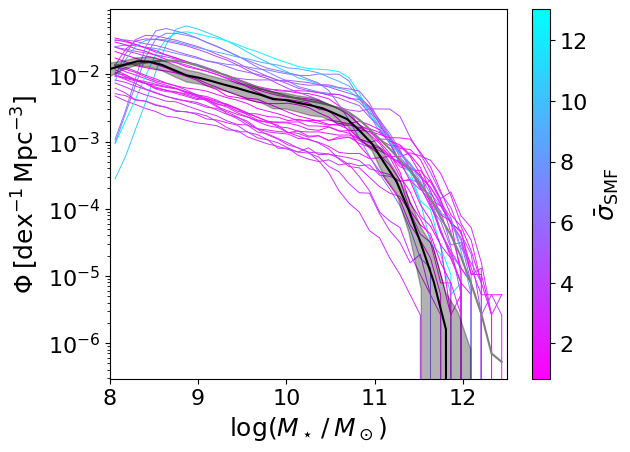

In [22]:
for i in range(n_sams):
    plt.plot(bins_avg, smf_arr[i], lw=0.7, color=colors[i])
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')

smf_mean = np.mean(smf_arr, axis=0)
smf_std = np.std(smf_arr, axis=0)
plt.plot(bins_avg, smf_mean, color='grey')
# plt.fill_between(bins_avg, 
#                  (smf_mean-smf_std), 
#                  (smf_mean+smf_std),
#                  color='magenta', alpha=0.3, lw=2,
#                  label='pSMF all')
    
plt.plot(ms, psmf_bgs_mean, color='black')
plt.fill_between(ms, 
                 psmf_bgs_mean-psmf_bgs_std, 
                 psmf_bgs_mean+psmf_bgs_std,
                 color='black', alpha=0.3,
                 zorder=10000,
                 label='BGS pSMF')
    
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')
plt.xlim(8, 12.5)

## Set up bacco P(k) code

In [35]:
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':True,
                  'kmin':0.01,
                  'kmax':1.0,
                  'nbins':32,
                  'correct_grid':True,
                  'log_binning':True,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'normalise_grid': True,
                  'compute_power2d':False}

In [36]:
import logging
logger = logging.getLogger("bacco.power")
# only log really bad events
logger.setLevel(logging.ERROR)

In [37]:
ndens_target = 0.003

vol_hMpc = 100**3 # units Mpc/h!! 
n_target = int(ndens_target * vol_hMpc)

In [38]:
pks = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        
        mstar_raw = np.array(f['mstar'])
        i_target = np.argsort(mstar_raw)[::-1][:n_target] # order by mstar and take largest to smallest to get desired ndens
        x_arr, y_arr, z_arr = f['x_position'], f['y_position'], f['z_position']
        pos_arr = np.array([x_arr, y_arr, z_arr]).T
        pos_arr = pos_arr[i_target]
        
        pk = bacco.statistics.compute_powerspectrum(pos=pos_arr, **args_power)
        pks.append(pk)

2024-01-16 14:00:46,091 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:46,092 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:46,093 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-16 14:00:46,094 bacco.statistics : starting deposit 1
2024-01-16 14:00:46,115 bacco.statistics :  mesh done in 0.0223 s
2024-01-16 14:00:46,116 bacco.statistics :  Starting the power spectrum calculation
2024-01-16 14:00:46,353 bacco.statistics :  done compute.power
2024-01-16 14:00:46,354 bacco.statistics :  power done in 0.263 s
2024-01-16 14:00:46,375 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:46,377 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:46,377 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-16 14:00:46,378 bacco.statistics : starting deposit 1
2024-01-16 14:00:46,414 bacco.statistics :  m

acco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3000 (grid1) 3000 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.059334 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.086267 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000078 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 3000 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_s

2024-01-16 14:00:46,967 bacco.statistics :  done compute.power
2024-01-16 14:00:46,968 bacco.statistics :  power done in 0.279 s
2024-01-16 14:00:46,987 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:46,988 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:46,988 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-16 14:00:46,989 bacco.statistics : starting deposit 1
2024-01-16 14:00:47,018 bacco.statistics :  mesh done in 0.0294 s
2024-01-16 14:00:47,018 bacco.statistics :  Starting the power spectrum calculation
2024-01-16 14:00:47,254 bacco.statistics :  done compute.power
2024-01-16 14:00:47,254 bacco.statistics :  power done in 0.268 s
2024-01-16 14:00:47,281 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:47,283 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:47,283 bacco.statistics : Computing cic mesh with ngrid=256

 interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3000 (grid1) 3000 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.063239 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.117652 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000558 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 3000 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1

2024-01-16 14:00:48,413 bacco.statistics :  done compute.power
2024-01-16 14:00:48,414 bacco.statistics :  power done in 0.26 s
2024-01-16 14:00:48,434 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:48,435 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:48,436 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-16 14:00:48,436 bacco.statistics : starting deposit 1
2024-01-16 14:00:48,474 bacco.statistics :  mesh done in 0.0381 s
2024-01-16 14:00:48,487 bacco.statistics :  Starting the power spectrum calculation
2024-01-16 14:00:48,715 bacco.statistics :  done compute.power
2024-01-16 14:00:48,716 bacco.statistics :  power done in 0.281 s
2024-01-16 14:00:48,738 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:48,740 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:48,741 bacco.statistics : Computing cic mesh with ngrid=256 

log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3000 (grid1) 3000 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.053348 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.100282 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000263 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 3000 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3000 (grid1) 3000 (grid2)
bacco.power : Doing FFTW
bacco.power: F

2024-01-16 14:00:49,917 bacco.statistics :  done compute.power
2024-01-16 14:00:49,918 bacco.statistics :  power done in 0.309 s
2024-01-16 14:00:49,938 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:49,940 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:49,940 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-16 14:00:49,941 bacco.statistics : starting deposit 1
2024-01-16 14:00:49,970 bacco.statistics :  mesh done in 0.0299 s
2024-01-16 14:00:49,971 bacco.statistics :  Starting the power spectrum calculation
2024-01-16 14:00:50,208 bacco.statistics :  done compute.power
2024-01-16 14:00:50,209 bacco.statistics :  power done in 0.271 s
2024-01-16 14:00:50,232 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:50,234 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:50,234 bacco.statistics : Computing cic mesh with ngrid=256

econvolve_grid2=1
bacco.power : total mass 3000 (grid1) 3000 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.054848 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.101262 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000554 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 3000 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3000 (grid1) 3000 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.069286 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.12

2024-01-16 14:00:51,360 bacco.statistics :  done compute.power
2024-01-16 14:00:51,361 bacco.statistics :  power done in 0.286 s
2024-01-16 14:00:51,384 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:51,385 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:51,385 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-16 14:00:51,386 bacco.statistics : starting deposit 1
2024-01-16 14:00:51,411 bacco.statistics :  mesh done in 0.0264 s
2024-01-16 14:00:51,412 bacco.statistics :  Starting the power spectrum calculation
2024-01-16 14:00:51,617 bacco.statistics :  done compute.power
2024-01-16 14:00:51,618 bacco.statistics :  power done in 0.234 s
2024-01-16 14:00:51,634 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:51,636 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:51,636 bacco.statistics : Computing cic mesh with ngrid=256

TW
bacco.power: FFT took 0.059719 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.102629 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000239 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 3000 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3000 (grid1) 3000 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.053108 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.125638 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000271 s

2024-01-16 14:00:52,756 bacco.statistics :  done compute.power
2024-01-16 14:00:52,757 bacco.statistics :  power done in 0.301 s
2024-01-16 14:00:52,776 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:52,779 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:52,780 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-16 14:00:52,781 bacco.statistics : starting deposit 1
2024-01-16 14:00:52,806 bacco.statistics :  mesh done in 0.0263 s
2024-01-16 14:00:52,807 bacco.statistics :  Starting the power spectrum calculation
2024-01-16 14:00:53,035 bacco.statistics :  done compute.power
2024-01-16 14:00:53,037 bacco.statistics :  power done in 0.261 s
2024-01-16 14:00:53,056 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:53,057 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:53,059 bacco.statistics : Computing cic mesh with ngrid=256

ing modes in 0.094480 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000250 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 3000 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3000 (grid1) 3000 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.057429 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.126295 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000348 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=1

2024-01-16 14:00:54,218 bacco.statistics :  done compute.power
2024-01-16 14:00:54,219 bacco.statistics :  power done in 0.259 s
2024-01-16 14:00:54,241 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:54,242 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:54,243 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-16 14:00:54,243 bacco.statistics : starting deposit 1
2024-01-16 14:00:54,274 bacco.statistics :  mesh done in 0.0317 s
2024-01-16 14:00:54,275 bacco.statistics :  Starting the power spectrum calculation
2024-01-16 14:00:54,542 bacco.statistics :  done compute.power
2024-01-16 14:00:54,543 bacco.statistics :  power done in 0.302 s
2024-01-16 14:00:54,564 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-16 14:00:54,565 bacco.statistics :  setting the grid 256 True
2024-01-16 14:00:54,565 bacco.statistics : Computing cic mesh with ngrid=256

In [40]:
pks[0]['k']

array([0.01077105, 0.01249609, 0.01449741, 0.01681924, 0.01951293,
       0.02263803, 0.02626363, 0.03046989, 0.03534981, 0.04101127,
       0.04757944, 0.05519954, 0.06404004, 0.07429639, 0.08619535,
       0.09999999, 0.11601552, 0.13459602, 0.15615229, 0.1811609 ,
       0.21017478, 0.24383539, 0.28288692, 0.32819276, 0.38075457,
       0.44173443, 0.51248054, 0.59455701, 0.68977847, 0.80025015,
       0.92841445, 1.07710495])

Text(0, 0.5, '$P(k)$')

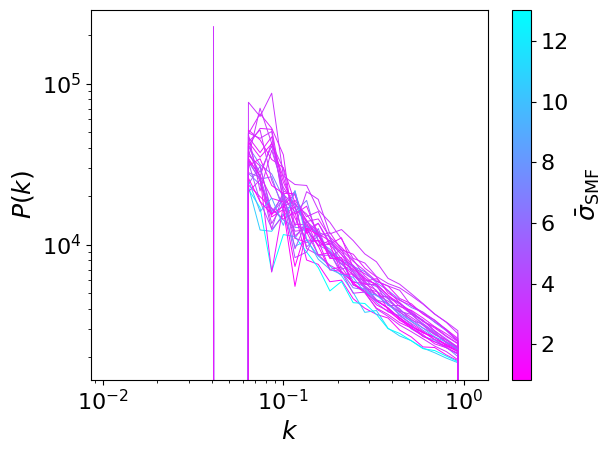

In [39]:
for i in range(n_sams):
    plt.plot(pks[i]['k'], pks[i]['pk'], lw=0.7, color=colors[i])
    
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

In [22]:
k_sam_all = pks[0]['k'] # same for all 

## Load bacco emu

In [23]:
emulator = baccoemu.Lbias_expansion()

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when u

/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when u

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 w

Nonlinear l-bias emulator loaded in memory.
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [24]:
#k = np.logspace(-1.9, np.log10(emulator.emulator['nonlinear']['k'].max()), num=100)

In [25]:
# should this match camels??
cosmo_params = {
    'omega_cold'    :  Om,
    'sigma8_cold'   :  sigma8, # if A_s is not specified
    'omega_baryon'  :  Ob,
    'ns'            :  ns,
    'hubble'        :  hubble,
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [26]:
#k, pnn = emulator.get_nonlinear_pnn(k=k, **params)

### Fit bias params

In [27]:
def ln_like(free_params, k_data, pk_data, variance,
            nbar, emulator, cosmo_params):
    bias_params = free_params[:4]
    A_sn = free_params[-1]
    _, pk_gg, _ = emulator.get_galaxy_real_pk(bias=bias_params, k=k_data,
                                             **cosmo_params)
    pk_model = pk_gg + A_sn/nbar
    delta_y = pk_data - pk_gg
    lnlk = 0.5 * np.sum((delta_y/variance)**2)
    #lnlk = 0.5 * delta_y.T @ C_inv @ delta_y
    return lnlk

In [28]:
i_bins = k_sam_all < 0.75
k_sam = k_sam_all[i_bins]
C_inv = np.diag(np.ones(len(k_sam))/len(k_sam))

In [29]:
bias_param_names = ['b1', 'b2', 'bs2', 'bl']
bias_param_labels = {'b1': r'$b_1$', 
                     'b2': r'$b_2$', 
                     'bs2': r'$b_{s^2}$', 
                     'bl': r'$b_{\nabla^2 \delta}$',
                    }
free_param_names = bias_param_names + ['Asn']
bounds_dict = {'b1': [-5, 20],
                'b2': [-5, 10],
                'bs2': [-10, 20],
                'bl': [-20, 30],
                'Asn': [0, 2],
                }
bounds = [bounds_dict[param_name] for param_name in free_param_names]

In [30]:
n_fit = 1

In [31]:
free_params_0 = [0.5, 0.5, 1.0, -1.0, 1.0]
res_arr = []
var_arr = []
for i in range(n_fit):
    print(f"Fitting SAM {i}")
    pk_sam = pks[i]['pk'][i_bins]
    
    err_poisson = pks[i]['shotnoise'][i_bins]
    err_1p = 0.01*pk_sam
    variance = err_poisson**2 + err_1p**2
    var_arr.append(variance)

    res = scipy.optimize.minimize(ln_like, free_params_0, bounds=bounds, 
                                  args=(k_sam, pk_sam, variance, nbar_arr[i], emulator, cosmo_params))
    res_arr.append(res)

Fitting SAM 0


In [32]:
print(np.sum([res['success'] for res in res_arr]))

1


In [38]:
np.sqrt(var_arr)

array([[198.8754322 ,  68.7864599 ,  46.4526397 ,  29.20770642,
         25.79731874,  22.72414214,  21.68547301,  20.95977223,
         20.36073061,  20.11933434,  19.80542695,  19.64598926]])

Text(0.5, 0, '$k$')

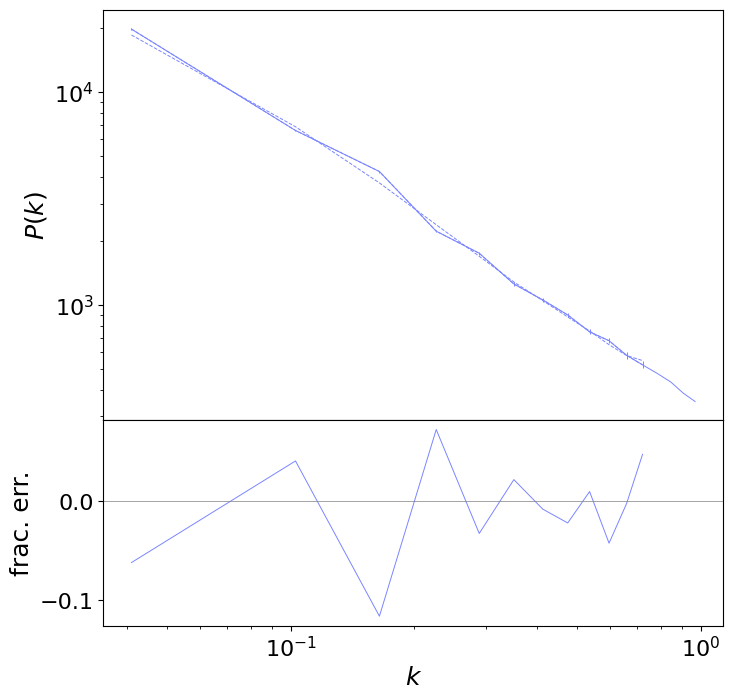

In [36]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(8,8), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0)

for i in range(n_fit):
    axarr[0].plot(pks[i]['k'], pks[i]['pk'], lw=0.7, color=colors[i])
    axarr[0].errorbar(k_sam, pks[i]['pk'][i_bins], yerr=np.sqrt(var_arr[i]), lw=0.7, ls='--', color=colors[i])
    bias_params = res_arr[i]['x'][:4]
    _, pk_emu, _ = emulator.get_galaxy_real_pk(bias=bias_params, k=k_sam, **cosmo_params)
    axarr[0].plot(k_sam, pk_emu, lw=0.7, ls='--', color=colors[i])
    axarr[0].set_ylabel(r'$P(k)$')
    
    axarr[1].plot(k_sam, (pk_emu-pks[i]['pk'][i_bins])/pks[i]['pk'][i_bins], lw=0.7, color=colors[i])
    axarr[1].set_ylabel('frac. err.')
    axarr[1].axhline(0, color='grey', lw=0.5)

plt.xscale('log')
axarr[0].set_yscale('log')
plt.xlabel(r'$k$')

## Plot bias params

Text(0.5, 0, '$b_1$')

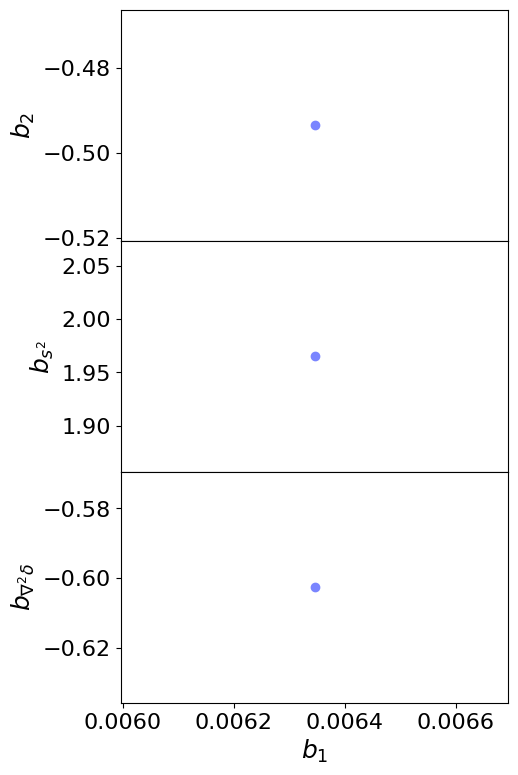

In [34]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(5, 3*nrows), sharex=True)
plt.subplots_adjust(hspace=0)

for i in range(n_fit):
    bias_params = res_arr[i]['x']
    for bb in range(1,len(bias_param_names)):
        axarr[bb-1].plot(bias_params[0], bias_params[bb], marker='o', markersize=6, color=colors[i])
        axarr[bb-1].set_ylabel(bias_param_labels[bias_param_names[bb]])

plt.xlabel(bias_param_labels[bias_param_names[0]])